In [2]:
import pandas as pd
import os

# Load Data

In [84]:
BASE_PATH = '/Users/amanchopra/Documents/School/MS/Fall 2023/RL/Final Project/Data/Raw'
tslim_1 = pd.read_csv(f'{BASE_PATH}/tslim_therapy_data_2-18-23_5-18-23.csv')
tslim_2 = pd.read_csv(f'{BASE_PATH}/tslim_therapy_data_5-18-23_8-18-23.csv')
bg_1 = pd.read_csv(f'{BASE_PATH}/bg_data_2-18-23_5-18-23.csv')
bg_2 = pd.read_csv(f'{BASE_PATH}/bg_data_5-18-23_8-18-23.csv')
hr = pd.read_csv(f'{BASE_PATH}/heart_rate_data_12-12-20_8-18-23.csv')
workout = pd.read_csv(f'{BASE_PATH}/workout_data_12-12-20_8-18-23.csv')
basal_energy = pd.read_csv(f'{BASE_PATH}/basal_energy_burned_data_12-12-20_8-18-23.csv')
active_energy = pd.read_csv(f'{BASE_PATH}/active_energy_burned_data_12-12-20_8-18-23.csv')

<ipython-input-84-a32670eebd6d>:6: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  hr = pd.read_csv(f'{BASE_PATH}/heart_rate_data_12-12-20_8-18-23.csv')
<ipython-input-84-a32670eebd6d>:8: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  basal_energy = pd.read_csv(f'{BASE_PATH}/basal_energy_burned_data_12-12-20_8-18-23.csv')
<ipython-input-84-a32670eebd6d>:9: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  active_energy = pd.read_csv(f'{BASE_PATH}/active_energy_burned_data_12-12-20_8-18-23.csv')


# Process

In [138]:
import re

def process_tslim(df):
    df = df.reset_index()
    df.columns = list(df.columns[2:]) + ['', '']
    df = df[['CompletionDateTime', 'Description', 'BG', 'InsulinDelivered']]
    df['CompletionDateTime'] = pd.to_datetime(df['CompletionDateTime'])
    df = df.rename(columns={'CompletionDateTime': 'Time'})
    return df

def process_bg(df):
    df = df.reset_index()
    df.columns = list(df.columns[1:]) + ['']
    df = df[['EventDateTime', 'Readings (CGM / BGM)']]
    df['EventDateTime'] = pd.to_datetime(df['EventDateTime'])
    df = df.rename(columns={'EventDateTime': 'Time', 'Readings (CGM / BGM)': 'BG'})
    return df

def process_body_metrics(df, metric):
    df = df.rename(columns={'sourceVersion': 'Time', 'unit': metric})[['Time', metric]].reset_index(drop=True)
    df['Time'] = pd.to_datetime(df['Time'])   
    return df

def process_workout(df):
    df = df[['startDate', 'endDate', 'workoutActivityType']]
    df['workoutActivityType'] = df['workoutActivityType'].str[len('HKWorkoutActivityType'):]
    df['workoutActivityType'] = df['workoutActivityType'].map(lambda x: ' '.join(re.split('(?<=.)(?=[A-Z])', x)))
    df = df.rename(columns={'startDate': 'StartTime', 'endDate': 'EndTime', 'workoutActivityType': 'WorkoutName'})
    return df


In [86]:
bg_1 = process_bg(bg_1)
bg_2 = process_bg(bg_2)

tslim_1 = process_tslim(tslim_1)
tslim_2 = process_tslim(tslim_2)

hr = process_body_metrics(hr, 'HR')
basal_energy = process_body_metrics(basal_energy, 'BE')
active_energy = process_body_metrics(active_energy, 'AE')

workout = process_workout(workout)

<ipython-input-85-182b2b45a197>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['workoutActivityType'] = df['workoutActivityType'].str[len('HKWorkoutActivityType'):]
<ipython-input-85-182b2b45a197>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['workoutActivityType'] = df['workoutActivityType'].map(lambda x: ' '.join(re.split('(?<=.)(?=[A-Z])', x)))


# Process and Merge

Let's start with BG data and determine an evenly spaced time interval.

In [100]:
bg = pd.concat([bg_1, bg_2]).sort_values('Time')
tslim = pd.concat([tslim_1, tslim_2]).sort_values('Time')

In [88]:
bg['Time'].diff().describe()

count                        36696
mean     0 days 00:07:07.831126008
std      0 days 06:17:24.584862979
min                0 days 00:00:00
25%                0 days 00:05:00
50%                0 days 00:05:00
75%                0 days 00:05:00
max               50 days 04:43:54
Name: Time, dtype: object

Seems like measurements are collected every 5 min on average.

In [115]:
bg['Time'] = bg['Time'].dt.round('5min')
bg = bg.groupby('Time')['BG'].mean().to_frame().reset_index()

bg_daterange = pd.date_range(start='2023-02-18 06:55:00', end='2023-08-18 23:55:00', freq='5T')
bg_processed = bg_daterange.to_frame().rename(columns={0: 'Time'})
bg_processed = bg_processed.reset_index(drop=True)
bg = pd.concat([bg, bg_processed]).sort_values('Time')
bg = bg.groupby('Time').mean().reset_index()
bg.head()

,Time,BG
0,2023-02-18 06:55:00,250.0
1,2023-02-18 07:00:00,242.0
2,2023-02-18 07:05:00,239.0
3,2023-02-18 07:10:00,237.0
4,2023-02-18 07:15:00,237.0


Now, let's process tslim data in similar way.

In [133]:
tslim['Time'] = tslim['Time'].dt.round("5min")
tslim = tslim.groupby('Time').agg({'BG': 'mean', 'InsulinDelivered': 'sum'}).reset_index()

tslim_daterange = pd.date_range(start='2023-02-18 07:40:00', end='2023-08-18 22:25:00', freq='5T')
tslim_processed = tslim_daterange.to_frame().rename(columns={0: 'Time'})
tslim_processed = tslim_processed.reset_index(drop=True)
tslim = pd.concat([tslim, tslim_processed]).sort_values('Time')
tslim = tslim.groupby('Time').mean().reset_index()
tslim['InsulinDelivered'] = tslim['InsulinDelivered'].fillna(0)
tslim.head()

,Time,BG,InsulinDelivered
0,2023-02-18 07:40:00,216.0,0.59
1,2023-02-18 07:45:00,NaN,0.00
2,2023-02-18 07:50:00,NaN,0.00
3,2023-02-18 07:55:00,NaN,0.00
4,2023-02-18 08:00:00,NaN,0.00


In [152]:
bg_tslim_merged = bg.merge(tslim, how='outer', left_on='Time', right_on='Time')
bg_tslim_merged['BG_x'] = bg_tslim_merged['BG_x'].fillna(bg_tslim_merged['BG_y'])
bg_tslim_merged = bg_tslim_merged.rename(columns={'BG_x': 'BG'})
bg_tslim_merged = bg_tslim_merged[['Time', 'BG', 'InsulinDelivered']]
bg_tslim_merged['Time'] = bg_tslim_merged['Time'].dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
bg_tslim_merged.head()

,Time,BG,InsulinDelivered
0,2023-02-18 01:55:00-05:00,250.0,NaN
1,2023-02-18 02:00:00-05:00,242.0,NaN
2,2023-02-18 02:05:00-05:00,239.0,NaN
3,2023-02-18 02:10:00-05:00,237.0,NaN
4,2023-02-18 02:15:00-05:00,237.0,NaN


In [155]:
hr['Time'] = hr['Time'].dt.round("5min")
hr = hr.groupby('Time')['HR'].mean().reset_index()

hr_daterange = pd.date_range(start='2020-12-13 18:25:00-07:00', end='2023-08-19 18:35:00-07:00', freq='5T')
hr_processed = hr_daterange.to_frame().rename(columns={0: 'Time'})
hr_processed = hr_processed.reset_index(drop=True)
hr = pd.concat([hr, hr_processed]).sort_values('Time')
hr = hr.groupby('Time').mean().reset_index()
hr = hr.ffill()
hr = hr[hr['Time'].isin(bg_tslim_merged['Time'])]
hr.head()

,Time,HR
229314,2023-02-17 23:55:00-07:00,58.0
229315,2023-02-18 00:00:00-07:00,58.0
229316,2023-02-18 00:05:00-07:00,58.0
229317,2023-02-18 00:10:00-07:00,58.0
229318,2023-02-18 00:15:00-07:00,58.0


In [158]:
final_merged = bg_tslim_merged.merge(hr, how='left', left_on='Time', right_on='Time')
final_merged = final_merged[~final_merged['InsulinDelivered'].isna()].reset_index(drop=True)
final_merged.head()

,Time,BG,InsulinDelivered,HR
0,2023-02-18 02:40:00-05:00,229.0,0.59,58.0
1,2023-02-18 02:45:00-05:00,217.0,0.00,58.0
2,2023-02-18 02:50:00-05:00,228.0,0.00,58.0
3,2023-02-18 02:55:00-05:00,226.0,0.00,58.0
4,2023-02-18 03:00:00-05:00,229.0,0.00,58.0


In [160]:
BASE_PATH = '/Users/amanchopra/Documents/School/MS/Fall 2023/RL/Final Project/Data/Processed'
final_merged.to_csv(f'{BASE_PATH}/merged.csv')

# EDA

In [168]:
import pandas as pd

BASE_PATH = '/Users/amanchopra/Documents/School/MS/Fall 2023/RL/Final Project/Data/Processed'
final_merged = pd.read_csv(f'{BASE_PATH}/merged.csv', index_col=0)[['BG', 'InsulinDelivered', 'HR']]
final_merged

,BG,InsulinDelivered,HR
0,229.0,0.59,58.000000
1,217.0,0.00,58.000000
2,228.0,0.00,58.000000
3,226.0,0.00,58.000000
4,229.0,0.00,58.000000
...,...,...,...
52301,205.0,0.00,81.400000
52302,200.0,0.00,78.786885
52303,194.0,0.00,69.101695
52304,187.0,0.00,67.846154


In [173]:
import seaborn as sns

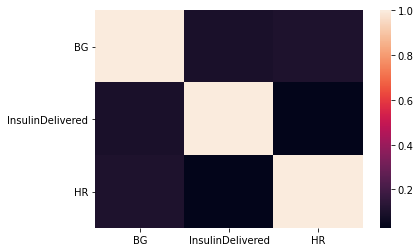

In [172]:
sns.heatmap(final_merged.corr())

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


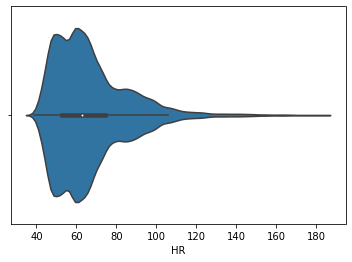

In [175]:
sns.violinplot(final_merged['HR'])

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


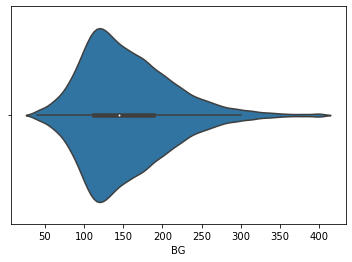

In [176]:
sns.violinplot(final_merged['BG'])

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


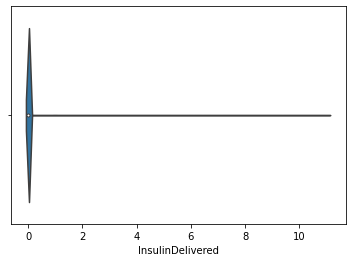

In [177]:
sns.violinplot(final_merged['InsulinDelivered'])

Let's make a transition model out of this data.

In [182]:
final_merged['BG_t1'] = final_merged['BG'].shift()
final_merged['BG_t2'] = final_merged['BG'].shift(2)
final_merged['BG_t3'] = final_merged['BG'].shift(3)

final_merged['HR_t1'] = final_merged['HR'].shift()
final_merged['HR_t2'] = final_merged['HR'].shift(2)
final_merged['HR_t3'] = final_merged['HR'].shift(3)

final_merged['InsulinDelivered_t1'] = final_merged['InsulinDelivered'].shift()
final_merged = final_merged.rename(columns={'BG': 'BG_t0', 'HR': 'HR_t0'})
final_merged = final_merged[['BG_t0', 'BG_t1', 'HR_t0', 'HR_t1', 'InsulinDelivered_t1', 'BG_t2', 'BG_t3', 'HR_t2', 'HR_t3']]
final_merged

,BG_t0,BG_t1,HR_t0,HR_t1,InsulinDelivered_t1,BG_t2,BG_t3,HR_t2,HR_t3
0,229.0,NaN,58.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,217.0,229.0,58.000000,58.000000,0.59,NaN,NaN,NaN,NaN
2,228.0,217.0,58.000000,58.000000,0.00,229.0,NaN,58.000000,NaN
3,226.0,228.0,58.000000,58.000000,0.00,217.0,229.0,58.000000,58.000000
4,229.0,226.0,58.000000,58.000000,0.00,228.0,217.0,58.000000,58.000000
...,...,...,...,...,...,...,...,...,...
52301,205.0,212.0,81.400000,77.533333,0.00,217.0,224.0,74.250000,78.351852
52302,200.0,205.0,78.786885,81.400000,0.00,212.0,217.0,77.533333,74.250000
52303,194.0,200.0,69.101695,78.786885,0.00,205.0,212.0,81.400000,77.533333
52304,187.0,194.0,67.846154,69.101695,0.00,200.0,205.0,78.786885,81.400000


In [184]:
final_merged = final_merged.dropna().reset_index(drop=True)
final_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35792 entries, 0 to 35791
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   BG_t0                35792 non-null  float64
 1   BG_t1                35792 non-null  float64
 2   HR_t0                35792 non-null  float64
 3   HR_t1                35792 non-null  float64
 4   InsulinDelivered_t1  35792 non-null  float64
 5   BG_t2                35792 non-null  float64
 6   BG_t3                35792 non-null  float64
 7   HR_t2                35792 non-null  float64
 8   HR_t3                35792 non-null  float64
dtypes: float64(9)
memory usage: 2.5 MB


In [185]:
BASE_PATH = '/Users/amanchopra/Documents/School/MS/Fall 2023/RL/Final Project/Data/Processed'
final_merged.to_csv(f'{BASE_PATH}/transition_model.csv')